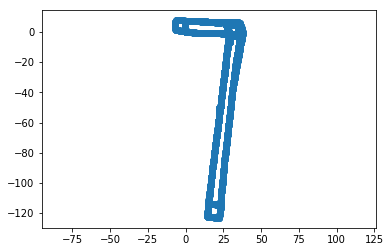

In [5]:
"""Extracts position of camera from ORBSLAM2 output"""

# Python 3.6

import os
import sys
import struct
import numpy as np
import pandas as pd
import quaternion
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

ROT_MAT = np.array([[0, 0, 1], [-1, 0, 0], [0, -1, 0]])
FPS = 30


class Pose():
    def __init__(self, time_stamp, t, q):
        self.time_stamp = time_stamp
        self.t = t
        self.q = q


def read_cameras_text(path):
    poses = []
    x_arr = []; y_arr = []; z_arr = []

    with open(path, "r") as fid:
        while True:
            line = fid.readline()
            if not line:
                break
            line = line.strip()
            if len(line) > 0 and line[0] != "#":
                elems = line.split()
                time_stamp = float(elems[0])
                t = np.array([float(elems[1]), float(elems[2]), float(elems[3])])
                t = np.dot(ROT_MAT, t)
                t[2] = 0.0
                q = np.array([float(elems[4]), float(elems[5]), float(elems[6]), float(elems[7])])
                poses.append(Pose(time_stamp=time_stamp, t=t, q=q))
    return poses


def find_angle(ref_q, q):
    rqvec = np.quaternion(ref_q[0], ref_q[1], ref_q[2], ref_q[3])
    qvec = np.quaternion(q[0], q[1], q[2], q[3])
    new_q = rqvec.inverse()*qvec
    ang = np.dot(np.array([0,1,0]), quaternion.as_rotation_vector(new_q))*180/np.pi
    angle = ang % 360
    return angle


def stitch(poses1, poses2, scale, angle, x, y):
    poses2 = scale_poses(poses2, poses1, scale)
    poses2 = rotate_poses(poses2, angle)
    intersection = poses1[-1]
    delta = intersection.t - poses2[0].t 
    reconstruction = poses1
    for pose in poses2:
        pose.t = pose.t + delta
        reconstruction.append(pose)
    return reconstruction

def scale_poses(poses, ref, scale):
    dist = []
    ref_dist = []
    for idx in range(len(poses)-1):
        dist.append(np.linalg.norm(poses[idx+1].t - poses[idx].t) / (poses[idx+1].time_stamp - poses[idx].time_stamp))
    for idx in range(len(ref)-1):
        ref_dist.append(np.linalg.norm(ref[idx+1].t - ref[idx].t) / (ref[idx+1].time_stamp - ref[idx].time_stamp))
    avg_dist = np.average(dist)
    avg_ref_dist = np.average(ref_dist)
    scale_factor = avg_ref_dist / avg_dist

    for pose in poses:
        pose.t = pose.t *scale_factor *scale 

    return poses

def rotate_poses(poses, angle):
    rot_point = poses[0].t 
    rot_mat = np.array([[np.cos(np.deg2rad(angle)), -np.sin(np.deg2rad(angle)), 0], \
                        [np.sin(np.deg2rad(angle)), np.cos(np.deg2rad(angle)), 0],  \
                        [0, 0, 1]])
    for pose in poses:
        tvec = pose.t - rot_point
        tvec = np.dot(rot_mat, tvec)
        pose.t = rot_point + tvec

    return poses


'''def filter_poses(poses):
    filtered = []
    x_arr = []; y_arr = []; z_arr = []
    done = False
    curr_idx = 0
    filtered.append(poses[0])
    done = False
    
    while not done:
        for idx, pose in enumerate(poses[curr_idx:]):
            dist = np.linalg.norm(pose.t - poses[curr_idx].t)
            if dist > 1:
                filtered.append(pose)
                x_arr.append(pose.t[0])
                y_arr.append(pose.t[1])
                z_arr.append(pose.t[2])
                curr_idx = idx
                continue
        done = True

    for i in range(len(poses)):  
        for idx, pose in enumerate(poses[curr_idx:]):
            dist = np.linalg.norm(pose.t - poses[curr_idx].t)
            if (dist > 1):
                filtered.append(pose)
                x_arr.append(pose.t[0])
                y_arr.append(pose.t[1])
                z_arr.append(pose.t[2])
                curr_idx = idx
                continue

    return filtered, x_arr, y_arr, z_arr'''


def save_poses(filename, poses):
    col = ['frame', 'x', 'y', 'z', 'angle']
    data = pd.DataFrame(columns=col)

    ref_pose = poses[0]
    for idx, pose in enumerate(poses):
        angle = find_angle(ref_pose.q, pose.q)
        frame = pose.time_stamp*FPS
        d = {'frame': frame, 'x':pose.t[0], 'y':pose.t[1], 'z':pose.t[2], 'angle':angle}
        data.loc[idx] = pd.Series(d)
        print("frame :" + str(frame) + "  angle: " + str(angle))
        np.save('poses.npy', data.values)


def plot_poses(poses):
    x = []; y = []; z = [];
    for pose in poses:
        x.append(pose.t[0])
        y.append(pose.t[1])
        z.append(pose.t[2])
    plot_data(x, y, z)
    #fig = plt.figure()
    #img = plt.imread("map.png")
    #fig, ax = plt.subplots()
    #ax.imshow(img)
    #ax.plot(x, y)
    #plt.show()


def plot_data(x, y, z):
    # Plot the poses
    '''fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x, y, z, c='r', marker='o')
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    #ax.axis('equal')
    ax.set_xlim3d(-50,80)
    ax.set_ylim3d(-120,10)
    ax.set_zlim3d(-1,1)'''
    plt.scatter(x, y)
    plt.axis('equal')
    plt.show()


folder = "/home/martin/hyrule-data/poses/"
plot = True

reconstructions = {}
for idx in range(18):
    reconstructions["{:02d}".format(idx + 1)] = read_cameras_text(folder + "{:02d}".format(idx + 1) + '.txt')
test = stitch(reconstructions['01'], reconstructions['02'], 1.0, -10.0, 0.0, 0.0)
#test = stitch(test, reconstructions['03'], 1.0, -90.0, 0.0, 0.0)
#test = stitch(test, reconstructions['04'], 1.1, 185.0, 0.0, 0.0)
#test = stitch(test, reconstructions['05'])
#test = stitch(test, reconstructions['06'])
#test = stitch(test, reconstructions['07'])
#test = stitch(test, reconstructions['08'])
#test = stitch(test, reconstructions['09'])
#test = stitch(test, reconstructions['10'])




#save_poses(filename, poses)
#filtered_poses, x_f, y_f, z_f = filter_poses(poses)

if plot:
    plot_poses(test)
    #plot_data(x1 + x2, y1 + y2, z1 + z2)
    #plot_data(x_f, y_f, z_f)


